# Natural Language Processing

O objetivo deste projeto é a criação de um modelo de Machine Learning de classificação utilizado o processamento de linguagem natural. O modelo irá classificar os comentários em três classes: "Positivo", "Negativo" e "Neutro". O conjunto de comentários negativos possui um alto valor de informação para empresas, podendo ser utilizado como feedback de melhoria e/ou base de dados para análise de causa raiz. 

## 1. Importando Bibliotecas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import spacy
from nltk import tokenize, RSLPStemmer, FreqDist, tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.lm import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from string import punctuation
from time import time
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from gensim.models.word2vec import Word2Vec
from collections import defaultdict


from utils.regex_utils import *
from utils.stopword_utils import RemoverStopwords
from utils.normalize_utils import ProcessoNormalizacao
from utils.stemming_utils import ProcessoStemming
from utils.features_extract import ExtracaoFeatures, E2V_IDF
from utils.n_grams_utils import ngrams_count
from utils.wordcloud_utils import nuvem_palavras
from utils.select_model_utils import print_score_BayesSearchCV, print_score
from utils.word2vec_utils import E2V_IDF

## 2. Leitura dos dados

O projeto foi desenvolvido utilizado um conjunto de dados público de e-commerce brasileiro de pedidos feitos na Olist Store, a maior loja de departamentos dos marketplaces brasileiros. A Olist conecta pequenas empresas de todo o Brasil a canais sem complicações e com um único contrato. Esses comerciantes podem vender seus produtos através da Olist Store e enviá-los diretamente aos clientes usando os parceiros de logística da Olist. O dataset possui informações de 100 mil pedidos de 2016 a 2018 feitos em vários marketplaces no Brasil. 

A base de dados de reviews foi construída a partir compras de produtos por clientes na Olist Store. Assim que o cliente recebe o produto, ou vence a data prevista de entrega, o cliente recebe uma pesquisa de satisfação por e-mail onde pode dar uma nota da experiência de compra e anotar alguns comentários.

In [3]:
dataset = pd.read_csv('order_reviews.csv', sep=';')

In [4]:
dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## 3. Compreensão de dados

### 3.1. Analise de dados faltantes (Null)

In [5]:
dataset.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title', 'order_id'], axis=1, inplace=True)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            99224 non-null  int64 
 1   review_comment_message  40977 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [7]:
# Retirando o valores Null de reviews
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset.shape

(40977, 2)

In [8]:
dataset.head()

,review_score,review_comment_message
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


### 3.1. Rotulagem dos dados

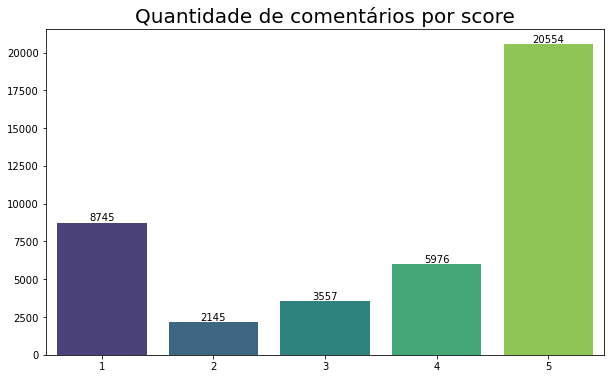

In [9]:
# Criando um datafrem que contem as quantidade de acordo com o score
quantidade = pd.DataFrame(dataset['review_score'].value_counts()).sort_index()

# plotando o gráfico de barra
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(y='review_score', x=quantidade.index, data=quantidade, orient='v', palette='viridis')
ax.set_title('Quantidade de comentários por score', fontdict={'fontsize': 20})
ax.set(ylabel=None, xlabel=None)
ax.bar_label(ax.containers[0])
plt.show()

Com objetivo de criar um modelo de análise sentimental em uma abordagem de Machine Learning supervisionado, iremos dividir os sentimentos em três classes: negativo, neutro e positivo. O database não possui uma definição explicita sobre a definição de sentimento para cada comentário. Pensando em uma implementação rápida, utilizaremos a coluna "review_score" para rotular os dados nas três classes já que ela dá uma uma ideia sobre a satisfação do cliente a respeito da compra.

Rotulagem dos dados:
- Positivo (1): Compreende os scores de valores 4 e 5
- Neutro (0): Compreende o score de valor 3
- Negativo (-1): Compreende os scores de valores 1 e 2


In [10]:
# Rotulagem dos dados
score_map = {
    1: -1,
    2: -1,
    3: 0,
    4: 1,
    5: 1
}

dataset['sentiment_label'] = dataset['review_score'].map(score_map)
dataset = dataset[['review_score', 'sentiment_label','review_comment_message']]

In [11]:
dataset.head()

,review_score,sentiment_label,review_comment_message
0,5,1,Recebi bem antes do prazo estipulado.
1,5,1,Parabéns lojas lannister adorei comprar pela I...
2,4,1,aparelho eficiente. no site a marca do aparelh...
3,4,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,1,"Vendedor confiável, produto ok e entrega antes..."


In [12]:
dataset['sentiment_label'].value_counts()

 1    26530
-1    10890
 0     3557
Name: sentiment_label, dtype: int64

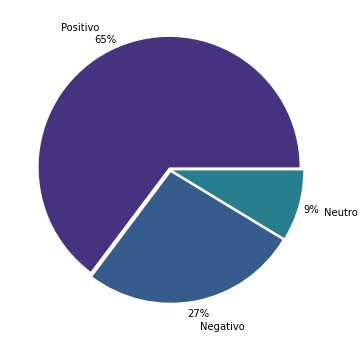

In [13]:
sentiment = pd.DataFrame(dataset['sentiment_label'].value_counts())
labels = ['Positivo', 'Negativo', 'Neutro']

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('viridis')
ax.pie(sentiment['sentiment_label'],labels= labels,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, explode = [0.02, 0.02, 0.02], colors=colors)
plt.show()

## 4. Criando uma BaseLine

Iremos definir uma baseline para o modelo de classificação de sentimos supervisionado. A baseline é um modelo simples de previsão que atua como referência para futuros modelos de Machine Learning, algumas informações aqui descritas serão explicadas e demostradas ao longo do projeto.

### 4.1. Bag of Words: criando representações da linguagem humana.

In [46]:
# Vetorizando as 50 palavras com mais ocorrência da coluna "review_comment_message"
vetorizar = CountVectorizer(max_features=50)
bag_of_words = vetorizar.fit_transform(dataset['review_comment_message'])
bag_of_words.shape

(40977, 50)

In [47]:
# Visualização das 50 palavras com mais ocorrência
print(vetorizar.get_feature_names_out())

['ainda' 'antes' 'as' 'até' 'bem' 'bom' 'chegou' 'com' 'como' 'compra'
 'comprei' 'da' 'de' 'dentro' 'do' 'em' 'entrega' 'entregue' 'estou' 'eu'
 'excelente' 'foi' 'gostei' 'loja' 'mais' 'mas' 'me' 'meu' 'minha' 'muito'
 'na' 'no' 'não' 'os' 'para' 'por' 'prazo' 'produto' 'qualidade' 'que'
 'recebi' 'recomendo' 'rápida' 'super' 'só' 'tudo' 'um' 'uma' 'veio'
 'ótimo']


### 4.2. Modelo: LogisticRegression 

In [16]:
# verificar a proporção do review score
dataset.review_score.value_counts().sort_index()

1     8745
2     2145
3     3557
4     5976
5    20554
Name: review_score, dtype: int64

In [50]:
regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')
scorer = make_scorer(f1_score, average = 'weighted')
scores = cross_val_score(regressao_logistica, bag_of_words, dataset['sentiment_label'], cv=10, scoring=scorer)
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

f1_score:[0.7567944  0.75861866 0.75916878 0.7594724  0.76023611 0.76070996
 0.76244324 0.76274105 0.77094021 0.77662594]
Média: 0.7627750743117272
Desvio Padrão: 0.005884688391941579


#### 4.2.1. Matriz de confusão

A matriz de confusão é a forma mais simples de analisar o desempenho de um algoritmo de classificação, sendo base para os cáculo das métricas dela derivadas.  

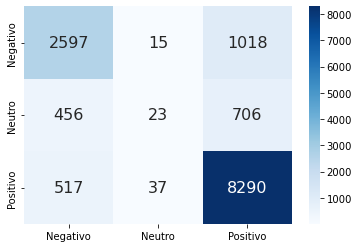

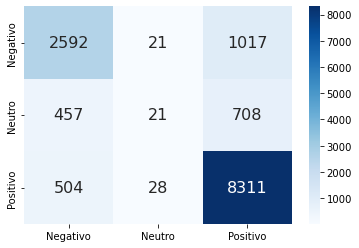

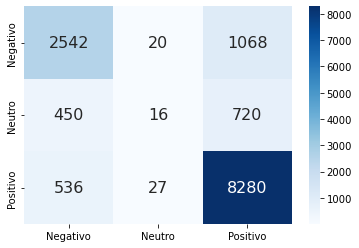

In [54]:
X = bag_of_words
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)
i = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=['Negativo', 'Neutro', 'Positivo'], columns=['Negativo', 'Neutro', 'Positivo'])
    plt.figure(i)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')
    i += i
    

#### 4.2.2. Precisão e Revocação

A metrica precisão do classificador (precision_score) é a acurácia das previsões positivas. O melhor valor é 1 e o pior valor é 0.

$$ precisão = \frac {TP}{TP + FP} $$

- TP: número de verdadeiros positivos
- FP: número de falsos positivos

A precisão é utilizada em conjunto com outra métrica chamada revocação (recall_score), também conhecida como sensibilidade ou taxa de verdadeiros positivos (TPR, do inglês): esta é a taxa de instâncias positivas que são corretamente detectadas pelo classificador.

$$ revocacão = \frac {TP}{TP + FN} $$

- TP: número de verdadeiros positivos
- FN: número de falsos negativos

#### 4.2.3. Pontuação F1

Uma forma simples de comparar dois classificadores é através da métrica chamada pontuação (F1). A pontuação F1 é a média harmônica da precisão e revocação. Enquanto a média regular trata igualmente todos os valores, a média harmônica dá muito mais peso aos valores mais baixos. Como resultado, o classificador só obterá uma pontuação F1 alta se a revocação e a precisão forem altas.

$$F_1 = \frac {2}{\frac {1}{precisão} + \frac {1}{revocacão}} = \frac {precisão * revocacão} {precisão + revocacão} = \frac {TP} {TP + \frac {FN + FP} {2}} $$

#### 4.2.4. Analise precisão, revocação e pontuação (f1) para cada classe:

In [52]:
# Definindo X e Y
X = bag_of_words
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7641533151796949
              precision    recall  f1-score   support

    negativo       0.73      0.72      0.72      3630
      neutro       0.31      0.02      0.04      1185
    positivo       0.83      0.94      0.88      8844

    accuracy                           0.80     13659
   macro avg       0.62      0.56      0.55     13659
weighted avg       0.76      0.80      0.76     13659

f1_score: 0.7647160778158226
              precision    recall  f1-score   support

    negativo       0.73      0.71      0.72      3630
      neutro       0.30      0.02      0.03      1186
    positivo       0.83      0.94      0.88      8843

    accuracy                           0.80     13659
   macro avg       0.62      0.56      0.55     13659
weighted avg       0.76      0.80      0.76     13659

f1_score: 0.7578329397156042
              precision    recall  f1-score   support

    negativo       0.72      0.70      0.71      3630
      neutro       0.25      0.01      0.0

## 5. Estrutura do Pipeline de trasformação dos dados

Será utilizado a classe Pipeline do Scikit Learn para executar uma preparação dos textos de cada comentário de forma automática, deixando pronto para treinamento e previsão do rótulo de sentimento. As etapas do pipeline são:

- Remoção das expressões regulares: sabendo que os dados são fruto de comentários da internet, será necessário lidar com algumas expressões regulares. Iremos realizar o pré-processamento dos dados, substituído as expressões regulares por termos que as caracterizem de forma simples;

- Remoção de StopWords: As stopwords são palavras que não apresentam relevância em determinado contexto e podem ser removidas sem perda semântica da frase;

- Normalização dos comentários: pega os dados Unicode e tenta representá-los em caracteres ASCII (ou seja, os caracteres universalmente exibíveis entre 0x00 e 0x7F), onde os compromissos assumidos ao mapear entre dois conjuntos de caracteres são escolhidos para estar perto do que um humano com um teclado americano escolheria;

- Stemming: Stemming é a técnica que transforma as flexões de uma palavra em um núcleo comum (tronco).  Essa técnica normaliza as palavras de forma a evitar suas flexões e derivações. Existem diversos algoritmos para realizar a “stemmização", seja em Português, sejam em outros idiomas;

- Extração de features: A extração de features de texto envolve resumir automaticamente o texto e encontrar palavras importantes. A extração de palavras poderá ser feita de duas formas:
    - CountVectorizer: converte uma coleção de documentos de texto em uma matriz de contagens de token, ou seja, produz uma representação esparsa das contagens de frequência das palavras ao longo de todo o dataset;
    - TF-IDF (Term Frequency-Inverse Document Frequency): é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.  O TF-IDF irá contar a frequência das palavras e atribui pesos as mesmas, ponderando-as em todo o dataset. Se uma palavra aparece muitas vezes, ela perde o poder de diferenciação, logo, possuirá um peso menor.


Todas as etapas do Pipeline foram modularizadas no diretório utils para tornar o programa mais "limpo".

In [ ]:
# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}

vectorizer = TfidfVectorizer(max_features=300) 

# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer())),
    ('text_features', ExtracaoFeatures(vectorizer))
])

In [ ]:
# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

## 6. Extração de features

### 6.1. CountVectorizer

O CountVectorizer converte uma coleção de documentos de texto em uma matriz de contagens de token , ou seja, essa implementação produz uma representação esparsa das contagens de frequência das palavras ao longo de todo o dataset.

In [42]:
def print_classification_report_ngrams(vectorizer, ngram, nsplits, maxfeatures=None, mindf=1, maxdf=1.0):
    regex_transformers = {
        'datas': re_dates,
        'valores_dinheiro': re_money,
        'numeros': re_numbers,
        'negacoes': re_negation,
        'caracteres_especiais': re_special_chars,
        'espacos_branco': re_whitespaces
    }

    vectorizer = vectorizer(max_features=300, ngram_range=ngram)

    # Criando o Pipeline
    text_pipeline = Pipeline([
        ('regex', RemoverRegex(regex_transformers)),
        ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
        ('normalization', ProcessoNormalizacao()),
        ('stemming', ProcessoStemming(RSLPStemmer())),
        ('text_features', ExtracaoFeatures(vectorizer))
    ])

    # Dfinido X e y 
    comentarios = dataset['review_comment_message'].dropna().index
    score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

    X = list(dataset['review_comment_message'][comentarios].values)
    y = score.values

    # Aplicando o pipeline
    X_processed = text_pipeline.fit_transform(X)

    # Cria 3 partições com os dados de disponíveis
    skf = StratifiedKFold(n_splits=nsplits)
    skf.get_n_splits(X_processed, y)


    for train_index, test_index in skf.split(X_processed, y):
        X_train, X_test = X_processed[train_index], X_processed[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #Criação do modelo
        regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', random_state=42, max_iter=200)

        regressao_logistica.fit(X_train, y_train)
        y_true, y_pred = y_test, regressao_logistica.predict(X_test)
        score = f1_score(y_true, y_pred, average='weighted')
        print(f'Score para n-grams {ngram}')
        print(f'f1_score: {score}')
        print(classification_report(y_true, y_pred))

#### 6.1.1. N-grams

In [50]:
print_classification_report_ngrams(CountVectorizer, ngram=(1,1), nsplits=5)

Score para n-grams (1, 1)
f1_score: 0.8103191701205052
              precision    recall  f1-score   support

    negativo       0.77      0.83      0.80      2178
      neutro       0.30      0.05      0.09       712
    positivo       0.88      0.95      0.91      5306

    accuracy                           0.84      8196
   macro avg       0.65      0.61      0.60      8196
weighted avg       0.80      0.84      0.81      8196

Score para n-grams (1, 1)
f1_score: 0.8113515397535156
              precision    recall  f1-score   support

    negativo       0.77      0.83      0.80      2178
      neutro       0.28      0.05      0.09       712
    positivo       0.88      0.95      0.91      5306

    accuracy                           0.84      8196
   macro avg       0.64      0.61      0.60      8196
weighted avg       0.80      0.84      0.81      8196

Score para n-grams (1, 1)
f1_score: 0.807308490271284
              precision    recall  f1-score   support

    negativo       

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score para n-grams (1, 1)
f1_score: 0.8053901199363199
              precision    recall  f1-score   support

    negativo       0.77      0.81      0.79      2178
      neutro       0.30      0.05      0.09       711
    positivo       0.87      0.95      0.91      5306

    accuracy                           0.83      8195
   macro avg       0.65      0.60      0.59      8195
weighted avg       0.79      0.83      0.81      8195

Score para n-grams (1, 1)
f1_score: 0.8082811865867747
              precision    recall  f1-score   support

    negativo       0.75      0.84      0.79      2178
      neutro       0.26      0.06      0.09       711
    positivo       0.89      0.94      0.91      5306

    accuracy                           0.83      8195
   macro avg       0.63      0.61      0.60      8195
weighted avg       0.80      0.83      0.81      8195



In [49]:
print_classification_report_ngrams(CountVectorizer, ngram=(2,2), nsplits=5)

Score para n-grams (2, 2)
f1_score: 0.7604942606801933
              precision    recall  f1-score   support

    negativo       0.77      0.66      0.71      2178
      neutro       0.29      0.02      0.03       712
    positivo       0.81      0.96      0.88      5306

    accuracy                           0.80      8196
   macro avg       0.62      0.54      0.54      8196
weighted avg       0.75      0.80      0.76      8196

Score para n-grams (2, 2)
f1_score: 0.7687174574326897
              precision    recall  f1-score   support

    negativo       0.78      0.69      0.73      2178
      neutro       0.29      0.01      0.03       712
    positivo       0.82      0.96      0.88      5306

    accuracy                           0.81      8196
   macro avg       0.63      0.55      0.55      8196
weighted avg       0.76      0.81      0.77      8196

Score para n-grams (2, 2)
f1_score: 0.7730275831930157
              precision    recall  f1-score   support

    negativo      

In [45]:
print_classification_report_ngrams(CountVectorizer, ngram=(2,3), nsplits=5)

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score para n-grams (2, 3)
f1_score: 0.7562545619784365
              precision    recall  f1-score   support

    negativo       0.78      0.64      0.70      2178
      neutro       0.31      0.02      0.03       712
    positivo       0.80      0.96      0.88      5306

    accuracy                           0.80      8196
   macro avg       0.63      0.54      0.54      8196
weighted avg       0.75      0.80      0.76      8196



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score para n-grams (2, 3)
f1_score: 0.7638448941495983
              precision    recall  f1-score   support

    negativo       0.78      0.67      0.72      2178
      neutro       0.31      0.01      0.02       712
    positivo       0.81      0.96      0.88      5306

    accuracy                           0.80      8196
   macro avg       0.63      0.55      0.54      8196
weighted avg       0.76      0.80      0.76      8196



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score para n-grams (2, 3)
f1_score: 0.7640853153310843
              precision    recall  f1-score   support

    negativo       0.78      0.67      0.72      2178
      neutro       0.32      0.01      0.02       711
    positivo       0.81      0.96      0.88      5306

    accuracy                           0.80      8195
   macro avg       0.64      0.55      0.54      8195
weighted avg       0.76      0.80      0.76      8195



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score para n-grams (2, 3)
f1_score: 0.7617759109680996
              precision    recall  f1-score   support

    negativo       0.78      0.66      0.72      2178
      neutro       0.42      0.01      0.02       711
    positivo       0.81      0.96      0.88      5306

    accuracy                           0.80      8195
   macro avg       0.67      0.55      0.54      8195
weighted avg       0.77      0.80      0.76      8195

Score para n-grams (2, 3)
f1_score: 0.7587756540102649
              precision    recall  f1-score   support

    negativo       0.77      0.66      0.71      2178
      neutro       0.18      0.01      0.02       711
    positivo       0.81      0.96      0.88      5306

    accuracy                           0.80      8195
   macro avg       0.59      0.54      0.53      8195
weighted avg       0.74      0.80      0.76      8195



Para todos os testes de n-grams utilizando o CountVectorizer obtivemos erros de convergência. Além disso, as métricas precision (presicão), recall (revocação) e f1-score não foram muito animadoras. Então vamos testar um método mais complexo onde leva em consideração a frequência das palavras e atribui um pesos para as mesmas.


### 6.2. TfidfVectorizer

O valor TF-IDF (Term Frequency-Inverse Document Frequency), é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.  O TF-IDF irá contar a frequência das palavras e atribui pesos as mesmas, ponderando-as em todo o dataset. Se uma palavra aparece muitas vezes, ela perde o poder de diferenciação, logo, possuirá um peso menor.


$$TF=\frac{\text{Frequency of a word in the document}}{\text{Total words in the document}}$$

$$IDF = \log\left({\frac{\text{Total number of docs}}{\text{Number of docs containing the words}}}\right)$$

#### 6.2.1. N-grams

Os modelos que estávamos utilizando até agora não gera um valor que preserve a sequência de palavras. O N-grams considera essencialmente uma sequência de palavras que aparecem na mesma "janela" ao mesmo tempo. Iremos testar modelos que com a utilização de N-grams:

In [46]:
print_classification_report_ngrams(TfidfVectorizer, ngram=(1,1), nsplits=5)

Score para n-grams (1, 1)
f1_score: 0.8094779032328606
              precision    recall  f1-score   support

    negativo       0.75      0.85      0.80      2178
      neutro       0.37      0.04      0.07       712
    positivo       0.89      0.94      0.91      5306

    accuracy                           0.84      8196
   macro avg       0.67      0.61      0.59      8196
weighted avg       0.80      0.84      0.81      8196

Score para n-grams (1, 1)
f1_score: 0.8138966260046941
              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      2178
      neutro       0.34      0.04      0.07       712
    positivo       0.89      0.94      0.91      5306

    accuracy                           0.84      8196
   macro avg       0.66      0.62      0.60      8196
weighted avg       0.81      0.84      0.81      8196

Score para n-grams (1, 1)
f1_score: 0.8101244733499022
              precision    recall  f1-score   support

    negativo      

In [47]:
print_classification_report_ngrams(TfidfVectorizer, ngram=(2, 2), nsplits=5)

Score para n-grams (2, 2)
f1_score: 0.7671277973494347
              precision    recall  f1-score   support

    negativo       0.77      0.70      0.73      2178
      neutro       0.39      0.01      0.02       712
    positivo       0.82      0.96      0.88      5306

    accuracy                           0.81      8196
   macro avg       0.66      0.55      0.54      8196
weighted avg       0.77      0.81      0.77      8196

Score para n-grams (2, 2)
f1_score: 0.7730944971690533
              precision    recall  f1-score   support

    negativo       0.76      0.72      0.74      2178
      neutro       0.44      0.01      0.02       712
    positivo       0.83      0.96      0.89      5306

    accuracy                           0.81      8196
   macro avg       0.68      0.56      0.55      8196
weighted avg       0.78      0.81      0.77      8196

Score para n-grams (2, 2)
f1_score: 0.7731951377091065
              precision    recall  f1-score   support

    negativo      

In [48]:
print_classification_report_ngrams(TfidfVectorizer, ngram=(2, 3), nsplits=5)

Score para n-grams (2, 3)
f1_score: 0.7621023947165763
              precision    recall  f1-score   support

    negativo       0.77      0.68      0.72      2178
      neutro       0.39      0.01      0.02       712
    positivo       0.81      0.96      0.88      5306

    accuracy                           0.80      8196
   macro avg       0.66      0.55      0.54      8196
weighted avg       0.76      0.80      0.76      8196

Score para n-grams (2, 3)
f1_score: 0.7678997903656416
              precision    recall  f1-score   support

    negativo       0.76      0.70      0.73      2178
      neutro       0.56      0.01      0.01       712
    positivo       0.82      0.96      0.88      5306

    accuracy                           0.81      8196
   macro avg       0.71      0.56      0.54      8196
weighted avg       0.78      0.81      0.77      8196

Score para n-grams (2, 3)
f1_score: 0.7674576555812515
              precision    recall  f1-score   support

    negativo      

Dentre os valores de n-grams testados anteriormente para o TfidfVectorizer, o único que será testado será Uni-gram (1,1), pois foi o que obtive o melhor f1-score para classificação da classe 'neutro'. Os demais n-grams até obtiveram valores interessante de precisão (precision), mas a revocação (recall) foram 0 ou 0.01.

#### 6.2.2. Analisando o max_features, min_df e max_df para Unigrams (ngram_range = (1,1))

- max_features: O hiperparâmetro considera apenas as principais features (palavras ou conjunto de palavras) ordenados por frequência de termo em todo o corpus.
- min_df: O hiperparâmetro define um limite para ignorar os termos que tenham uma frequência de documento estritamente inferior ao limite fornecido.
- max_df: O hiperparâmetro define um limite para ignorar os termos que têm uma frequência de documento estritamente superior ao limite determinado.

In [22]:
# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}

# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer()))
    ])

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

In [23]:
# Função para verificar a acuracia dos melhores valores de hiperparamentros
def hiperparamentros_tfidfVectorizer(X_processed, y, max_features, min_df, max_df, ngram=(1, 1)):
    col=['max_features', 'min_df', 'max_df', 'f1_score']
    list = []
    scorer = make_scorer(f1_score, average = 'weighted')
    for maxfeatures in max_features:
        for mindf in min_df:
            for maxdf in max_df:
                vectorizer = TfidfVectorizer(max_features=maxfeatures, min_df=mindf, max_df=maxdf, ngram_range=ngram)

                X = vectorizer.fit_transform(X_processed)

                #Criação do modelo
                regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', random_state=42)

                #aplicando a validação cruzada
                score = np.mean(cross_val_score(regressao_logistica, X, y, scoring=scorer, cv=StratifiedKFold(n_splits=5)))
                list.append([maxfeatures, mindf, maxdf, score])
    return pd.DataFrame(list, columns=col).sort_values('f1_score', ascending=False).reset_index(drop=True)

In [25]:
max_features = [300, 400, 500]
min_df = [0.05, 0.2, 0.3]
max_df = [0.8, 0.9, 0.95]

df_score = hiperparamentros_tfidfVectorizer(X_processed, y, max_features, min_df, max_df)
df_score.head(10)

,max_features,min_df,max_df,f1_score
0,300,0.05,0.80,0.757767
1,300,0.05,0.90,0.757767
2,300,0.05,0.95,0.757767
3,500,0.05,0.95,0.757767
4,500,0.05,0.90,0.757767
5,500,0.05,0.80,0.757767
6,400,0.05,0.80,0.757767
7,400,0.05,0.90,0.757767
8,400,0.05,0.95,0.757767
9,500,0.20,0.95,0.713766


É possível perceber que para os dez maiores valores de score calculado são para o min_df igual a 0.05, independente das variações dos outros hiperparâmetros. Então, vamos reajustar o valor de min_df e calcular novamente os valores de acurácia.

In [26]:
max_features = [300, 400, 500]
min_df = [0, 0.001, 0.005, 0.01, 0.05]
max_df = [0.7, 0.8, 0.9]

df_score = hiperparamentros_tfidfVectorizer(X_processed, y, max_features, min_df, max_df)
df_score.head(10)

,max_features,min_df,max_df,f1_score
0,500,0.001,0.7,0.814828
1,500,0.000,0.9,0.814828
2,500,0.000,0.7,0.814828
3,500,0.001,0.9,0.814828
4,500,0.001,0.8,0.814828
5,500,0.000,0.8,0.814828
6,400,0.000,0.9,0.812673
7,400,0.000,0.8,0.812673
8,400,0.000,0.7,0.812673
9,400,0.001,0.9,0.812613


Então, é possível visualizar as seguintes afirmações:
- Quanto menor o valor min_df melhor é acuracia do modelo;
- Quanto maior o valor max_features melhor é acuracia do modelo (podendo causar overfitting);
- O valor de max_df não contribuiu para melhora da acurácia para esse conjunto de hiperparâmetros.

In [27]:
max_features = [400, 500, 600]
min_df = [0, 0.001, 0.005]
max_df = [0.7, 0.8, 0.9]

df_score = hiperparamentros_tfidfVectorizer(X_processed, y, max_features, min_df, max_df)
df_score.head(20)

,max_features,min_df,max_df,f1_score
0,600,0.000,0.9,0.815768
1,600,0.000,0.8,0.815768
2,600,0.000,0.7,0.815768
3,600,0.001,0.9,0.815744
4,600,0.001,0.8,0.815744
5,600,0.001,0.7,0.815744
6,500,0.001,0.8,0.814828
7,500,0.001,0.9,0.814828
8,500,0.000,0.7,0.814828
9,500,0.000,0.8,0.814828


Aumentar o valor de features para melhora do modelo de classificação não resultou em grande melhora da acurácia (score) do modelo, mas em contrapartida aumento sua complexidade e podendo causar overfitting. Então vamos escolher o melhor conjunto de hiperparâmetros para o max_features igual a 400. Logo, vamos escolher o maior valor de min_df e o menor valor de max_df para tentar tornar o modelo mais genérico.

In [28]:
df_score[df_score['max_features'] == 400]

,max_features,min_df,max_df,f1_score
12,400,0.000,0.8,0.812673
13,400,0.000,0.7,0.812673
14,400,0.000,0.9,0.812673
15,400,0.001,0.9,0.812613
16,400,0.001,0.8,0.812613
17,400,0.001,0.7,0.812613
18,400,0.005,0.9,0.806506
22,400,0.005,0.8,0.806506
23,400,0.005,0.7,0.806506


Valores de hiperparâmetros selecionados:
- max_features = 400
- min_df = 0.001
- max_df = 0.7

In [34]:
print_classification_report_ngrams(TfidfVectorizer, ngram=(1,1), nsplits=5, maxfeatures=400, mindf=0.001, maxdf=0.7)

Score para n-grams (1, 1)
f1_score: 0.8094779032328606
              precision    recall  f1-score   support

    negativo       0.75      0.85      0.80      2178
      neutro       0.37      0.04      0.07       712
    positivo       0.89      0.94      0.91      5306

    accuracy                           0.84      8196
   macro avg       0.67      0.61      0.59      8196
weighted avg       0.80      0.84      0.81      8196

Score para n-grams (1, 1)
f1_score: 0.8138966260046941
              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      2178
      neutro       0.34      0.04      0.07       712
    positivo       0.89      0.94      0.91      5306

    accuracy                           0.84      8196
   macro avg       0.66      0.62      0.60      8196
weighted avg       0.81      0.84      0.81      8196

Score para n-grams (1, 1)
f1_score: 0.8101244733499022
              precision    recall  f1-score   support

    negativo      

### 6.3. Word2Vec

#### 6.3.1. Implementação Word2Vec pela biblioteca spaCy

A biblioteca spaCy possui modelos e pipelines treinados para serem utilizados em projetos de NLP. Será utilizado o modelo 'pt_core_news_sm'. A seguir temos uma simples demostração do funcionamento do modelo.

In [42]:
nlp = spacy.load("pt_core_news_sm")
doc = nlp("Esta é uma frase.")
print([(w.text, w.pos_) for w in doc])
print(doc.vector)

[('Esta', 'PRON'), ('é', 'AUX'), ('uma', 'DET'), ('frase', 'NOUN'), ('.', 'PUNCT')]
[ 1.6862637   1.0966642  -0.44830102  1.2407768   1.2119696   0.4967288
  1.1355568  -0.3789686  -0.23921096 -1.0028999   0.01694105  1.0304904
 -0.77945006 -1.8455906   0.14623375 -1.5098034   0.09465428  0.23753071
  0.7262373  -3.4491882  -0.06529514 -0.35115677  0.25457078  0.97570646
  1.3779566  -0.07742429  2.3602567   1.3939953  -1.0734911   0.51703084
 -0.06598546 -0.13703804 -1.6283951  -0.24659435 -2.7218637  -1.726352
  0.7910467  -0.3519574  -1.2363064   0.21610522  1.2061622  -1.2713051
  2.08051     2.0840862  -3.1898916  -0.1673429   1.206226    4.5296965
 -3.36494     0.5160467   0.7298645  -2.5763297  -1.0656779  -1.3060184
 -0.67010766 -2.3228176  -0.8842122   0.43415537  1.3984268   1.0577457
 -0.5068926   0.4359377  -1.6620098   0.45011562 -1.9427035   2.2010276
  0.07313128  1.7914689  -0.78537834 -0.7929416   0.62613255  4.374768
 -1.5901229   0.80564517 -1.8765942  -2.4415004   0

In [41]:
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}


# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer()))
])

# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)


X_processed_w2v = [nlp(review).vector for review in X_processed]


In [45]:
# Trasformando a lista X_processed_w2v em um dataframe
df_X_processed_w2v = pd.DataFrame(list(map(np.ravel, X_processed_w2v)))

In [72]:
# Selecionando os review_score 
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})
# Removendo os valores NaN gerados no processo de trasformação dos dados 
df_ml = pd.concat([df_X_processed_w2v, score], axis=1).dropna()

In [88]:
# Separando o dataset em X e Y
X = df_ml.iloc[:, :-1].values
y = df_ml.iloc[:,-1].values

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(df_ml.iloc[:, :-1], df_ml.iloc[:,-1])


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', random_state=42, max_iter=200)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'Score Word2Vec')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score Word2Vec
f1_score: 0.7391923520471352
              precision    recall  f1-score   support

    negativo       0.66      0.70      0.68      3627
      neutro       0.20      0.00      0.01      1182
    positivo       0.82      0.91      0.86      8797

    accuracy                           0.77     13606
   macro avg       0.56      0.54      0.52     13606
weighted avg       0.72      0.77      0.74     13606



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score Word2Vec
f1_score: 0.7423332638481633
              precision    recall  f1-score   support

    negativo       0.68      0.70      0.69      3626
      neutro       0.24      0.00      0.01      1183
    positivo       0.82      0.92      0.86      8797

    accuracy                           0.78     13606
   macro avg       0.58      0.54      0.52     13606
weighted avg       0.73      0.78      0.74     13606



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score Word2Vec
f1_score: 0.7390485884020849
              precision    recall  f1-score   support

    negativo       0.66      0.70      0.68      3626
      neutro       0.25      0.01      0.01      1182
    positivo       0.82      0.91      0.86      8797

    accuracy                           0.77     13605
   macro avg       0.58      0.54      0.52     13605
weighted avg       0.73      0.77      0.74     13605



#### 6.3.2. Implementação Word2Vec pela biblioteca nltk

A biblioteca nltk contem a classe Word2Vec que é um algoritmo para construir representações vetoriais de palavras, também conhecido como word embeddings. O vetor para cada palavra é uma descrição semântica de como essa palavra é usada no contexto, portanto, duas palavras que são usadas de maneira semelhante no texto terão representações vetoriais semelhantes. Depois de mapear palavras no espaço vetorial, você pode usar a matemática vetorial para encontrar palavras que tenham semântica semelhante. Para implementar o Word2Vec neste projeto, iremos treinar um modelo a partir da própria base de dados.

In [25]:
x_separado_por_palavra = list()
for item in  X_processed:
    x_separado_por_palavra.append(word_tokenize(item))

# Trasfoamando cada review em lista composta por todas as palavras
x_separado_por_palavra[0]

['receb', 'bem', 'ant', 'praz', 'estipul']

In [26]:
# Trasformando a lista de palavras em um array de palavras
X_w2v = np.array(x_separado_por_palavra)
X_w2v[:2]

C:\Users\Brothers\AppData\Local\Temp/ipykernel_7228/3021681431.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_w2v = np.array(x_separado_por_palavra)


array([list(['receb', 'bem', 'ant', 'praz', 'estipul']),
       list(['parab', 'loj', 'lannist', 'ador', 'compr', 'internet', 'segur', 'pra', 'parab', 'tod', 'feliz', 'pasco'])],
      dtype=object)

In [32]:
# Treinando os Embeddings com a Coleção
# sg=1 -- Skip Gram
model = Word2Vec(X_w2v, vector_size=300, window=5, sg=1, workers=4)
w2v = {w: vec for w, vec in zip(model.wv.index_to_key, model.wv.vectors)}
word_vectors = model.wv
len(w2v)

2300

In [36]:
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}

# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer())),
    ('w2v', E2V_IDF(w2v))
])

# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

In [37]:
# Representação de um review (conjunto de palavras) a partir do modelo word2vec
X_processed[0]

array([-6.75199600e-03,  1.86525151e-01,  3.83282751e-02,  8.33293274e-02,
       -6.05972251e-03, -1.31283864e-01,  7.21414313e-02,  3.08452785e-01,
        1.39897084e-02, -2.53857626e-03, -9.88215767e-03, -1.19019739e-01,
        4.32758071e-02, -1.93288624e-02, -8.33064616e-02, -4.78607975e-02,
        3.56259197e-02,  2.24428307e-02,  9.70229581e-02, -2.51476299e-02,
       -1.67030945e-01, -1.99590269e-02,  8.15033391e-02,  1.07512206e-01,
        1.54096887e-01,  4.03406434e-02, -1.77595034e-01,  7.23470375e-02,
       -6.42824918e-02, -1.50666609e-01,  2.05498617e-02, -1.12472296e-01,
        3.89049053e-02,  5.31133041e-02, -1.12498943e-02,  3.08047533e-02,
        1.25670940e-01, -1.24974258e-01, -7.52034187e-02,  2.23629754e-02,
        1.09653398e-02,  2.98187118e-02,  1.32519193e-02,  6.42805966e-03,
        1.07772395e-01,  1.13337703e-01, -4.08071466e-02,  6.76041795e-03,
        2.81910971e-02,  6.11983426e-02,  5.21695577e-02,  5.22530675e-02,
       -2.49724016e-02,  

In [38]:
# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_processed, y)


for train_index, test_index in skf.split(X_processed, y):
    X_train, X_test = X_processed[train_index], X_processed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', random_state=42, max_iter=200)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'Score para W2V_AVG')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

Score para W2V_AVG
f1_score: 0.6377204025022661


c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negativo       0.60      0.34      0.43      2178
      neutro       0.00      0.00      0.00       712
    positivo       0.71      0.93      0.81      5306

    accuracy                           0.69      8196
   macro avg       0.44      0.42      0.41      8196
weighted avg       0.62      0.69      0.64      8196

Score para W2V_AVG
f1_score: 0.6383020488751269


c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negativo       0.60      0.33      0.43      2178
      neutro       0.00      0.00      0.00       712
    positivo       0.71      0.94      0.81      5306

    accuracy                           0.70      8196
   macro avg       0.44      0.42      0.41      8196
weighted avg       0.62      0.70      0.64      8196

Score para W2V_AVG
f1_score: 0.6424177470207232


c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negativo       0.61      0.34      0.44      2178
      neutro       0.00      0.00      0.00       711
    positivo       0.72      0.94      0.81      5306

    accuracy                           0.70      8195
   macro avg       0.44      0.43      0.42      8195
weighted avg       0.62      0.70      0.64      8195

Score para W2V_AVG
f1_score: 0.6425486006567488


c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negativo       0.60      0.35      0.44      2178
      neutro       0.00      0.00      0.00       711
    positivo       0.72      0.93      0.81      5306

    accuracy                           0.70      8195
   macro avg       0.44      0.43      0.42      8195
weighted avg       0.62      0.70      0.64      8195

Score para W2V_AVG
f1_score: 0.640641982995776
              precision    recall  f1-score   support

    negativo       0.61      0.34      0.44      2178
      neutro       0.00      0.00      0.00       711
    positivo       0.71      0.94      0.81      5306

    accuracy                           0.70      8195
   macro avg       0.44      0.43      0.42      8195
weighted avg       0.62      0.70      0.64      8195



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 7. Modelos de Classificação de Sentimento

### 7.1. LogisticRegression

Alguns algoritmos de regressão também podem ser utilizados para classificação (e vice-versa). A Regressão Logística (também chamada de Regressão Logit) é comumente utilizada para estimar a probabilidade de uma instância pertencer a uma determinada classe. Assim como um modelo de Regressão Linear, um modelo de Regressão Logística calcula uma soma ponderada das características de entrada (mais um termo de polarização), mas, em vez de gerar o resultado diretamente como o modelo de Regressão Linear, gera a logística desse resultado.

O modelo de Regressão Logística pode ser generalizado para suportar múltiplas classes diretamente sem a necessidade de treinar e combinar vários classificadores binários. Isso é chamado Regressão Softmax, ou Regressão Logística Multinomial. A ideia é bem simples: quando dada uma instância x, o modelo de Regressão Softmax primeiro calcula uma pontuação sk(x) para cada classe k, então estima a probabilidade de cada classe aplicando a função softmax (também chamada exponencial normalizada) às pontuações.

Uma vez calculada a pontuação de cada classe para a instância x, você pode estimar a probabilidade Pk de a instância pertencer à classe k ao executar as pontuações através da função softmax: ela calcula a exponencial de cada pontuação e a normaliza (dividindo pela soma de todas as exponenciais). Assim como o classificador de Regressão Logística, o classificador de Regressão Softmax prevê a classe com a maior probabilidade estimada (que é simplesmente a classe com a maior pontuação).

#### 7.1.1. Recalculando a baseline

Iremos recalcular o score para o mesmo modelo que foi calculado a baseline, ou seja, iremos utilizar os mesmo hiperpâmetros para a LogisticRegression, mas iremos utilizar a base de dados tratada pelo Pipeline.

In [ ]:
# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}

vectorizer = TfidfVectorizer(max_features=500, min_df=0.001, max_df=0.7) 

# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer())),
    ('text_features', ExtracaoFeatures(vectorizer))
])

# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

Utilizaremos a função cross_val_score() para avaliar o modelo LogisticRegression com a utilização da validação cruzada K-fold com três partes. Lembre-se de que a validação cruzada K-fold significa dividir o conjunto de treinamento em K-folds (neste caso, três), prever e avaliar as previsões em cada conjunto utilizando um modelo treinado em conjuntos restantes.

In [29]:
regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')
scores = cross_val_score(regressao_logistica, X_processed, y, cv=3, scoring="accuracy")
print(f'Scores:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

Scores:[0.84017864 0.84318032 0.84405886]
Média: 0.8424726065841814
Desvio Padrão: 0.001661260943955625


Comparando os valores dos scores obtido e com os valores da baseline antes do tratamento dos dados é possível perceber um ganho de 4.7% na acurácia do modelo utilizando os mesmos hiperparâmetros para o modelo.

In [33]:
CR = classification_report(y_test, y_pred)
print(CR)

              precision    recall  f1-score   support

    negativo       0.75      0.84      0.79      2151
      neutro       0.34      0.05      0.08       730
    positivo       0.88      0.94      0.91      5315

    accuracy                           0.83      8196
   macro avg       0.66      0.61      0.59      8196
weighted avg       0.80      0.83      0.80      8196



Analisando as métricas para a classe "neutro" é possível confirmar de forma numérica o péssimo resultado de classificação para classe. As classes "negativo" e "possitivo" possui ótimas métricas, enquanto a classe "neutro" possui apenas 36% de precisão e 6% de revogação.

#### 7.1.2. Otimizando os hiperparamentors do modelo de LogisticRegression (BayesSearchCV)

A classe BayesSearchCV é uma otimização Bayesiana sobre hiperparâmetros. Os parâmetros do estimador usados ​​para aplicar esses métodos são otimizados por pesquisa de validação cruzada sobre configurações de parâmetros. Ao contrário do GridSearchCV, nem todos os valores de parâmetro são testados, mas um número fixo de configurações de parâmetro é amostrado das distribuições especificadas. O número de configurações de parâmetro que são tentadas é dado por n_iter.

In [18]:
 # log-uniform: understand as search over p = exp(x) by varying x

search_spaces=[{
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'multi_class': Categorical(['multinomial']),
  'penalty': Categorical(['l2', 'none']),
  'solver': Categorical(['lbfgs', 'sag']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}, {
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'penalty': Categorical(['l1', 'l2']),
  'solver': Categorical(['liblinear']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}]
n_iter = 40
model = LogisticRegression()
incial = time()
print_score_BayesSearchCV(model, X_processed, y, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 

Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 0.5151918020836844), ('class_weight', 'balanced'), ('max_iter', 100), ('penalty', 'l1'), ('solver', 'liblinear')])
f1_score (weighted): 0.8276859175154488

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.75      0.85      0.80      2151
      neutro       0.31      0.27      0.29       730
    positivo       0.92      0.89      0.91      5315

    accuracy                           0.83      8196
   macro avg       0.66      0.67      0.66      8196
weighted avg       0.82      0.83      0.82      8196

Tempo de execução: 61.76109137535095min


### 7.2. SVM (Support Vector Machines)

Uma Máquina de Vetores de Suporte (SVM) é um modelo muito poderoso e versátil de Aprendizado de Máquina capaz de realizar classificações lineares ou não lineares, de regressão e até mesmo detecção de outliers. As SVM são particularmente adequadas para a classificação de conjuntos de dados complexos. Dentro da modulo SVM iremos utilizar a classe SVC (C-Support Vector Classification.), no qual o suporte multiclasse é tratado de acordo com um esquema de um contra um.

Hiperparâmetro:
- C: Parâmetro de regularização. Um valor menor de C leva a uma via mais larga, mas com mais violações das margens.
- kernel: Especifica o tipo de kernel a ser usado no algoritmo. 
- coef0: controla o quanto o modelo é influenciado por polinômios de alto grau versus polinômios de baixo grau. Só é significativo em 'poli' e 'sigmóide'.
- gamma: Coeficiente de kernel para 'rbf', 'poli' e 'sigmoid'.
    - Se gamma='scale'(padrão) for passado, ele usará 1 / (n_features * X.var()) como valor de gama,
    - Se 'auto', usa 1 / n_features.


In [21]:
# Hiperparâmentros
tuned_parameters = {
    'C': [1.0],
    'kernel' : ['rbf'],
    'gamma': ['scale', 'auto'] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.819 (+/-0.010) for {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.678 (+/-0.023) for {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.75      0.89      0.81      2151
      neutro       0.27      0.02      0.04       730
    positivo       0.89      0.94      0.92      5315

    accuracy                           0.84      8196
   macro avg       0.64      0.62      0.59      8196
weighted avg       0.80      0.84      0.81      8196



Em uma primeira analise com o classificador SVC houve uma pequena melhora na classificação das classes 'negativo' e 'positivo', enquanto a classe 'neutro' piorou significativamente, se comparada com o melhor modelo de LogisticRegression. O custo computacional para o classificador SVC foi muito superior. A classe 'neutra' se manteve como a pior classe na classificação dos reveiws, se comparado com o modelo de LogisticRegression, teve uma queda de 0.09 em f1-score e 0.06 no recall. 

Iremos verificar o aumento do valor de 'C' e a definição do valor de 'gama' manualmente. O alto valor de C faz o classificador possuir menos violações na margem, mas fica com uma margem menor. Aumentar ‘gamma’ estreitará a curva em forma de sino, e como resultado cada raio de influência da instância será menor: mexer ao redor de instâncias individuais torna a fronteira de decisão mais irregular. Por outro lado, um pequeno valor de ‘gamma’ torna a curva em forma de sino mais ampla, de modo que as instâncias ficam com um maior raio de influência e o limite de decisão fica mais suave.


In [23]:
# Hiperparâmentros
tuned_parameters = {
    'C': [1.0, 100],
    'kernel' : ['rbf'],
    'gamma': [0.1, 10] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.807 (+/-0.003) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.580 (+/-0.014) for {'C': 1.0, 'gamma': 10, 'kernel': 'rbf'}
0.825 (+/-0.003) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.586 (+/-0.012) for {'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      2151
      neutro       0.32      0.10      0.15       730
    positivo       0.90      0.93      0.92      5315

    accuracy                           0.84      8196
   macro avg       0.66      0.63      0.63      8196
weighted avg       0.81      0.84      0.82      8196



A variação dos hiperparâmetros resultou em uma excelente melhora no modelo de classificação em todas as classes chegando a superar o melhor modelo de LogisticRegression. Em especial houve melhora na classe 'neutro', nas métricas recall e f1-score.

Como o melhor modelo encontrado possui um valor alto de do hiperparâmetros 'C', vamos verificar se aumentando ainda mais seu valor melhora o resultado da classificação:

In [20]:
# Hiperparâmentros
tuned_parameters = {
    'C': [200, 300],
    'kernel' : ['rbf'],
    'gamma': [0.1] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 200, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.823 (+/-0.006) for {'C': 200, 'gamma': 0.1, 'kernel': 'rbf'}
0.820 (+/-0.006) for {'C': 300, 'gamma': 0.1, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.84      0.80      2151
      neutro       0.25      0.10      0.15       730
    positivo       0.90      0.93      0.91      5315

    accuracy                           0.83      8196
   macro avg       0.63      0.62      0.62      8196
weighted avg       0.80      0.83      0.81      8196



O grande aumento do hiperparâmetro 'C' não resultou em melhora do modelo, mas resultou em um valor de f1-score bastante próximo do melhor modelo encontrodado. Então vamos verificar um valor de 'C' mais próximo de 100 (valor do melhor classificado):

In [21]:
# Hiperparâmentros
tuned_parameters = {
    'C': [125, 175],
    'kernel' : ['rbf'],
    'gamma': [0.1, 1] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 125, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.823 (+/-0.005) for {'C': 125, 'gamma': 0.1, 'kernel': 'rbf'}
0.821 (+/-0.004) for {'C': 125, 'gamma': 1, 'kernel': 'rbf'}
0.823 (+/-0.005) for {'C': 175, 'gamma': 0.1, 'kernel': 'rbf'}
0.821 (+/-0.004) for {'C': 175, 'gamma': 1, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.86      0.81      2151
      neutro       0.30      0.10      0.15       730
    positivo       0.90      0.93      0.91      5315

    accuracy                           0.84      8196
   macro avg       0.65      0.63      0.63      8196
weighted avg       0.81      0.84      0.82      8196



In [19]:
# Hiperparâmentros
tuned_parameters = {
    'C': [110, 112],
    'kernel' : ['rbf'],
    'gamma': [0.1] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.823 (+/-0.001) for {'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}
0.823 (+/-0.002) for {'C': 112, 'gamma': 0.1, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      2151
      neutro       0.32      0.10      0.15       730
    positivo       0.90      0.93      0.92      5315

    accuracy                           0.84      8196
   macro avg       0.66      0.63      0.63      8196
weighted avg       0.81      0.84      0.82      8196



Os resultados obtidos foram bastante similar com o modelo de parâmentros igual {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}. O valor de f1-score foi menor que 0.825 (+/-0.003), mas o desvio padrão foi menor (+/-0.001) para os três valores calculados para Cross-Validation.

O melhor modelo para o SVC selecionado será:

In [25]:
# Hiperparâmentros
tuned_parameters = {
    'C': [110],
    'kernel' : ['rbf'],
    'gamma': [0.1] 
}

model_SVC = SVC()
incial = time()
print_score(model_SVC, X_processed, y, tuned_parameters)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.824 (+/-0.003) for {'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      2151
      neutro       0.32      0.10      0.15       730
    positivo       0.90      0.93      0.92      5315

    accuracy                           0.84      8196
   macro avg       0.66      0.63      0.63      8196
weighted avg       0.81      0.84      0.82      8196

Tempo de execução: 46.78752770423889min


In [18]:
 # log-uniform: understand as search over p = exp(x) by varying x

search_spaces=[{
    'C': Real(1e-3, 1e+3, prior='log-uniform'),
    'kernel' : Categorical(['rbf']),
    'gamma': Real(0.1, 10, prior='log-uniform') 
}]

model = SVC()
n_iter = 50
incial = time()
print_score_BayesSearchCV(model, X_processed, y, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 

Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 5.114312906246165), ('gamma', 0.7052207811078224), ('kernel', 'rbf')])
f1_score (weighted): 0.8245544917624398

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.86      0.81      2151
      neutro       0.28      0.08      0.13       730
    positivo       0.90      0.93      0.91      5315

    accuracy                           0.84      8196
   macro avg       0.64      0.63      0.62      8196
weighted avg       0.80      0.84      0.82      8196

Tempo de execução: 670.8822413841883min
